# Predictive Modeling of Solid Holdup Distribution in Fluidized Chemical Reactors Using Machine Learning Algorithms


# Table of Contents

- [1. Background](#background)
- [2. Data Collection](#data-collection)
- [3. Data Cleaning](#data-cleaning)
- [4. Deploying Machine Learning Models](#deploying-machine-learning-models)  
  - [4.1 Linear Regression](#linear-regression)  
  - [4.2 K-Nearest Neighbors Regression (KNN)](#k-nearest-neighbors-regression-knn)  
  - [4.3 Support Vector Machine Regression (SVM)](#support-vector-machine-regression-svm)  
  - [4.4 Decision Tree Regression (DTR)](#decision-tree-regression-dtr)  
  - [4.5 Random Forest Regression (RFR)](#random-forest-regression-rfr)  
- [5. Comparing the Models](#comparing-the-models)  
- [6. Discussion and Conclusion](#discussion-and-conclusion)  
- [7. References](#references)  



# 1. Background

<div style="font-size:18px; line-height:1.8;">
In this work, I have used five different machine learning algorithms to predict the solids holdup distribution in three Liquid-Solid Circulating Fluidized Bed (LSCFB) reactors and to model their hydrodynamics. LSCFB reactors are widely used in chemical, biochemical, environmental, and petrochemical applications. However, investigating their hydrodynamics experimentally is expensive and requires significant resources, including large-scale reactors and hazardous chemicals. Additionally, certain aspects of these sophisticated reactors may be infeasible to study experimentally due to safety concerns and technical limitations. Therefore, developing reliable machine learning models capable of accurately representing experimental results is crucial for enhancing our understanding of LSCFB reactor behavior while reducing experimental costs and risks. 

# 2. Data Collection

<div style="font-size:18px; line-height:1.8;">
The experimental data used in this work were collected manually from two different LSCFBs: Razzak system (Razzak et al. 2020) and the Zheng system (Zheng et al. 2002). These data encompass a broad range of operating conditions, various radial and axial positions, and multiple parameters. 
    
The paramters involve in this model are:
- U<small>s</small> : superficial solids velocity (cm/s).
- Ul : superficial liquid velocity (cm/s).
- Ut : terminal settling velocity (cm/s).
- D  : Diameter of the particles (µm).
- x  : axial location in (m). 
- x/L: Dimensionless axial positions. 
- r/R: Dimensionless radial positions.

The targe is to build models that predict the experimental results of solids holdup distribution in fluidized bed reactor. Solids holdup in LSCFB refers to the fraction of the reactor volume occupied by solid particles within the liquid phase. It is a crucial parameter that influences the hydrodynamics, mass transfer, and overall performance of the reactor.

# 3. Data Cleaning

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,     
    median_absolute_error,   
    explained_variance_score)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')


In [33]:
# importing the data
Solid_holdup = pd.read_csv('Solid_Holdup.csv')
Solid_holdup.head()

,Us,Ul,Ut,D,x,x/L,r/R,Solids Holdup
0,0.75,11.2,7.1,500,1.0,0.17,0.00,0.0792
1,0.75,11.2,7.1,500,1.0,0.17,0.20,0.0792
2,0.75,11.2,7.1,500,1.0,0.17,0.49,0.0818
3,0.75,11.2,7.1,500,1.0,0.17,0.64,0.0844
4,0.75,11.2,7.1,500,1.0,0.17,0.76,0.0850


In [34]:
# Summary of the dataframe and checking there is missing entries
Solid_holdup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Us             392 non-null    float64
 1   Ul             392 non-null    float64
 2   Ut             392 non-null    float64
 3   D              392 non-null    int64  
 4   x              392 non-null    float64
 5   x/L            392 non-null    float64
 6   r/R            392 non-null    float64
 7   Solids Holdup  392 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 24.6 KB


In [35]:
# Statistics summary
round(Solid_holdup.describe(),2)

,Us,Ul,Ut,D,x,x/L,r/R,Solids Holdup
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,0.89,16.40,6.87,487.57,2.06,0.40,0.56,0.08
std,0.46,8.93,0.65,33.87,1.13,0.18,0.32,0.04
min,0.11,7.80,5.30,405.00,0.35,0.13,0.00,0.02
25%,0.40,10.00,7.10,500.00,1.00,0.25,0.20,0.06
50%,0.95,11.20,7.10,500.00,2.00,0.36,0.64,0.07
75%,1.19,22.40,7.10,500.00,3.00,0.53,0.86,0.11
max,1.72,35.00,7.30,508.00,3.82,0.73,0.95,0.26


In [36]:
# Checking duplicated entries
Solid_holdup.duplicated().sum()

# Droping duplicated entries
Solid_holdup = Solid_holdup.drop_duplicates(keep='first')

In [37]:
# Checking if there are any outliers

# Calculate the IQR
Q1 = Solid_holdup.quantile(0.25)
Q3 = Solid_holdup.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Corrected condition for outliers (element-wise comparison)
outliers = Solid_holdup[(Solid_holdup < lower_bound) | (Solid_holdup > upper_bound)]

if outliers.dropna().empty:
    print("The DataFrame is empty and contains no outliers")
else:
    print("The DataFrame contains outliers")

The DataFrame is empty and contains no outliers


# 4. Deploying Machine Learning Models 

In [38]:
#Prepare Features and Target
feature_cols = ["Us", "Ul", "Ut", "D", "x", "x/L", "r/R"]
X = Solid_holdup[feature_cols]
y = Solid_holdup["Solids Holdup"]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For reproducibility
np.random.seed(42)

## 4.1. Linear Regression

Performance Metrics DataFrame:
                           Metric     Value
0        Mean Squared Error (MSE)  0.000446
1  Root Mean Squared Error (RMSE)  0.021116
2                        R² Score  0.758623


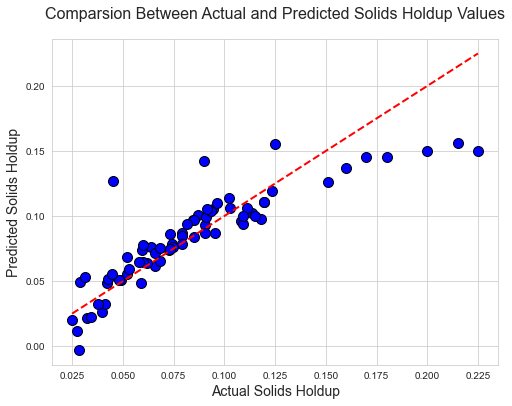

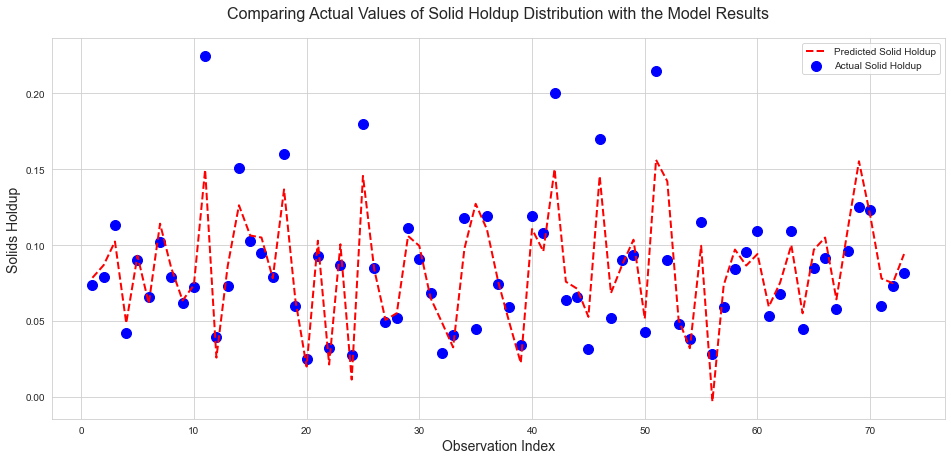

In [39]:
# Create and Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Function to create and display a performance metrics table
def get_metrics_dataframe(mse, rmse, r2):
    metrics_table = pd.DataFrame({
        "Metric": ["Mean Squared Error (MSE)",
                   "Root Mean Squared Error (RMSE)",
                   "R² Score"],
        "Value": [mse, rmse, r2]
    })
    
    return metrics_table

# call the function and get the DataFrame
metrics_LR = get_metrics_dataframe(mse, rmse, r2)
print("Performance Metrics DataFrame:")
print(metrics_LR)

# Calculate residuals
residuals = y_test - y_pred

# Function to plot Actual vs. Predicted values and Observation Index vs. Solids Holdup
def plot_comparison(y_test, y_pred):
    # Plot 1: Actual vs. Predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', edgecolor='k', s=100)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
    plt.xlabel("Actual Solids Holdup",fontsize =14)
    plt.ylabel("Predicted Solids Holdup",fontsize =14)
    plt.title("Comparsion Between Actual and Predicted Solids Holdup Values",fontsize =16,pad=20)
    plt.grid(True)
    plt.show()
    
    # Plot 2: Observation Index vs. Solids Holdup
    obs_index = np.arange(1, len(y_test) + 1)
    
    plt.figure(figsize=(16, 7))
    plt.scatter(obs_index, y_test, color='blue', s=100, label='Actual Solid Holdup')
    plt.plot(obs_index, y_pred, 'r--', lw=2, label='Predicted Solid Holdup')
    plt.xlabel("Observation Index",fontsize =14)
    plt.ylabel("Solids Holdup",fontsize =14)
    plt.title("Comparing Actual Values of Solid Holdup Distribution with the Model Results",fontsize =16,pad=20)
    plt.legend()
    plt.grid(True)
    plt.show()

# call the function
plot_comparison(y_test, y_pred)


## 4. 2. K-Nearest Neighbors Regression (KNN)

Best Hyperparameters: {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
Performance Metrics DataFrame:
                           Metric     Value
0        Mean Squared Error (MSE)  0.000344
1  Root Mean Squared Error (RMSE)  0.018548
2                        R² Score  0.813756


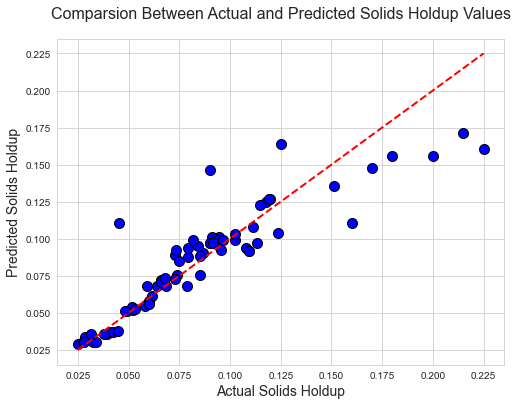

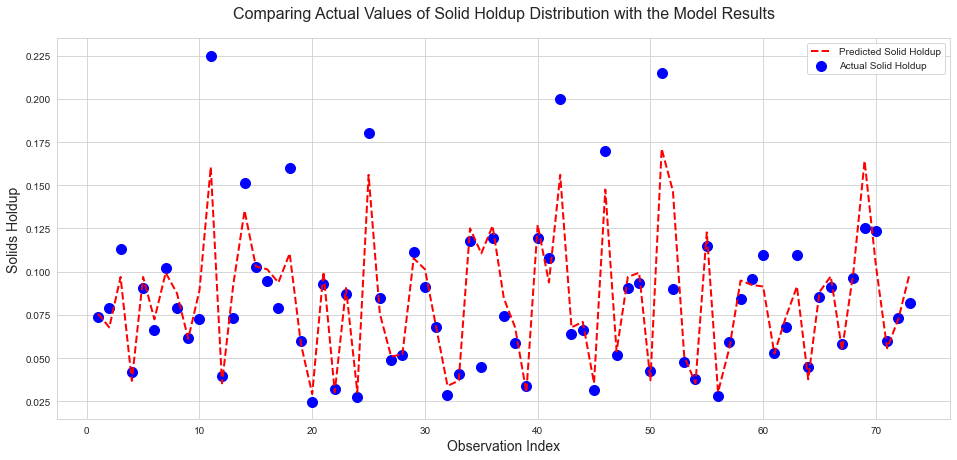

In [40]:
# Hyperparameter Tuning for K-Nearest Neighbors Regressor
param_grid = {
    "n_neighbors": [3, 5, 10, 15],  # Number of neighbors to use
    "weights": ["uniform", "distance"],  # Weight function used in prediction
    "p": [1, 2]  # Power parameter for Minkowski distance (1=Manhattan, 2=Euclidean)
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,  
    scoring="r2",  
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best model with optimized parameters
best_model = grid_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the Optimized Model and Make Predictions
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

## Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Call the function and get the DataFrame
metrics_KNN = get_metrics_dataframe(mse, rmse, r2)
print("Performance Metrics DataFrame:")
print(metrics_KNN)

# Calculate residuals
residuals = y_test - y_pred

# call the plot function
plot_comparison(y_test, y_pred)


## 4. 3. Support Vector Machine Regression (SVM)

Best Hyperparameters: {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'}
Performance Metrics DataFrame:
                           Metric     Value
0        Mean Squared Error (MSE)  0.000472
1  Root Mean Squared Error (RMSE)  0.021730
2                        R² Score  0.744384


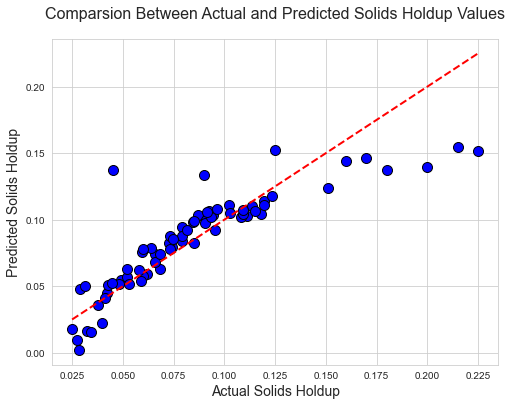

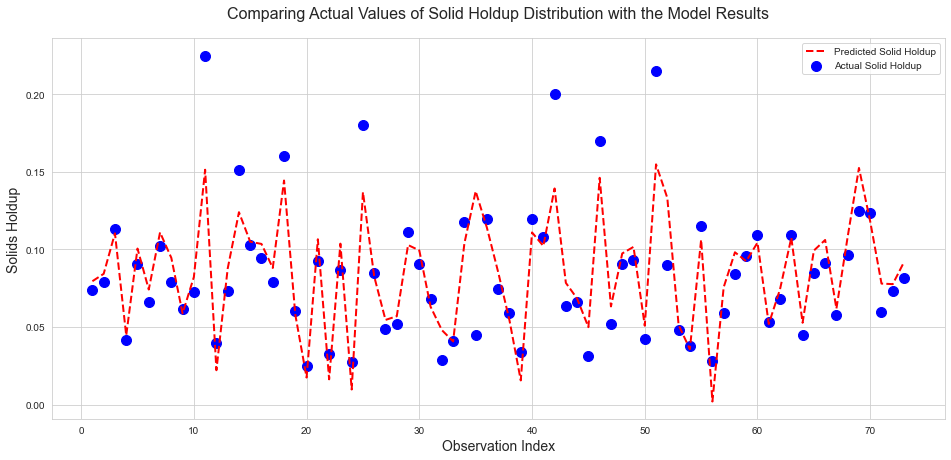

In [41]:
# Hyperparameter grid for SVM Regressor
param_grid = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],  
    "C": [0.1, 1, 10, 100], 
    "epsilon": [0.01, 0.1, 0.2, 0.5], 
    "degree": [2, 3, 4], 
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,  
    scoring="r2",  
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best model with optimized parameters
best_model = grid_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the Optimized Model and Make Predictions
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

## Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Call the function and get the metric DataFrame
metrics_SVM = get_metrics_dataframe(mse, rmse, r2)
print("Performance Metrics DataFrame:")
print(metrics_SVM)

# Calculate residuals
residuals = y_test - y_pred

# call the function plot function
plot_comparison(y_test, y_pred)


## 4. 4. Decision Tree Regression (DTR)

Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Performance Metrics DataFrame:
                           Metric     Value
0        Mean Squared Error (MSE)  0.000040
1  Root Mean Squared Error (RMSE)  0.006300
2                        R² Score  0.978514


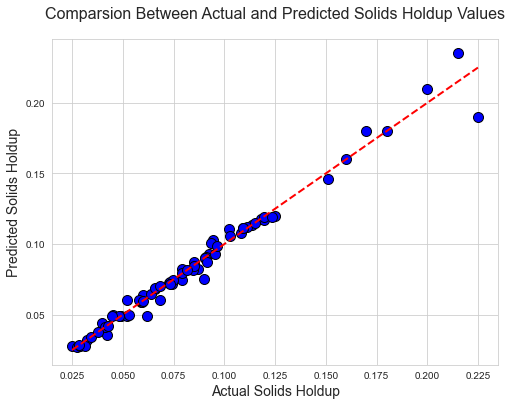

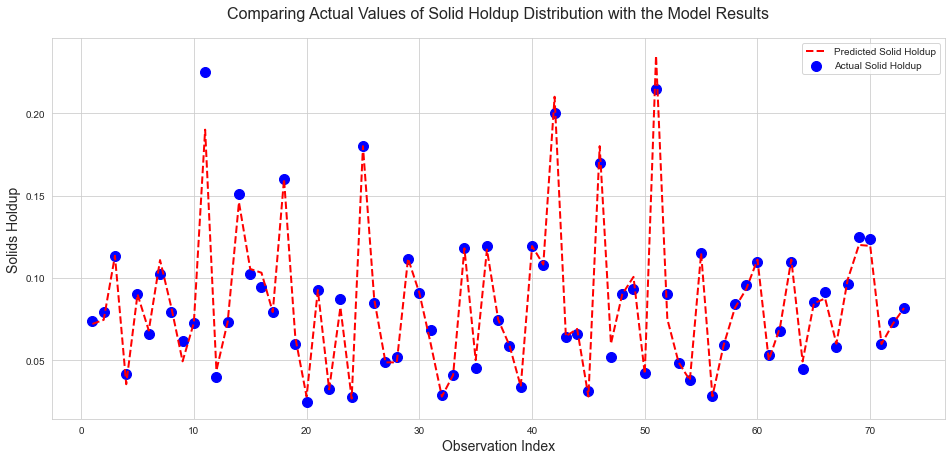

In [42]:
# Hyperparameter Tuning for Decision Tree Regressor
param_grid = {
    "max_depth": [3, 5, 10, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2", None]  
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    param_grid, 
    cv=5,  
    scoring="r2",  
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best model with optimized parameters
best_model = grid_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


# Train the Optimized Model and Make Predictions
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

## Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Call the function and get the metric DataFrame
metrics_DTR = get_metrics_dataframe(mse, rmse, r2)
print("Performance Metrics DataFrame:")
print(metrics_DTR)

# Calculate residuals
residuals = y_test - y_pred

# call the plot function
plot_comparison(y_test, y_pred)



## 4. 5. Random Forest Regression (RFR)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Performance Metrics DataFrame:
                           Metric     Value
0        Mean Squared Error (MSE)  0.000026
1  Root Mean Squared Error (RMSE)  0.005112
2                        R² Score  0.985852


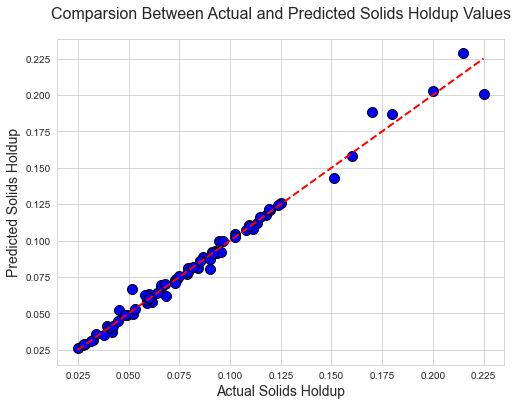

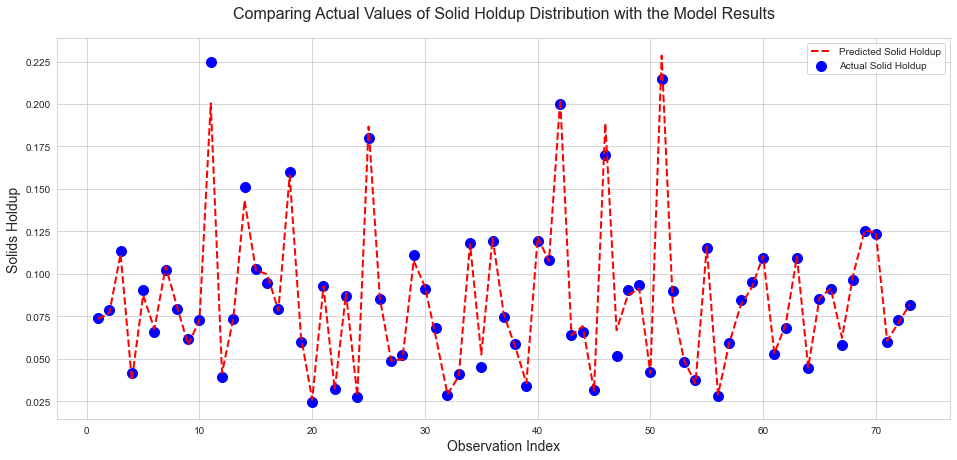

In [43]:
# Hyperparameter Tuning for Random Forest Regressor
param_grid = {
    "n_estimators": [50, 100, 200],         
    "max_depth": [3, 5, 10, None],            
    "min_samples_split": [2, 5, 10],          
    "min_samples_leaf": [1, 2, 4],            
    "max_features": ["sqrt", "log2", None]    
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    param_grid, 
    cv=5,  
    scoring="r2", 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best model with optimized parameters
best_model = grid_search.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the Optimized Model and Make Predictions
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


## Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Call the function and get the metric DataFrame
metrics_RFR = get_metrics_dataframe(mse, rmse, r2)
print("Performance Metrics DataFrame:")
print(metrics_RFR)

# Calculate residuals
residuals = y_test - y_pred

# call the plot function
plot_comparison(y_test, y_pred)


# 5. Comparing the Models

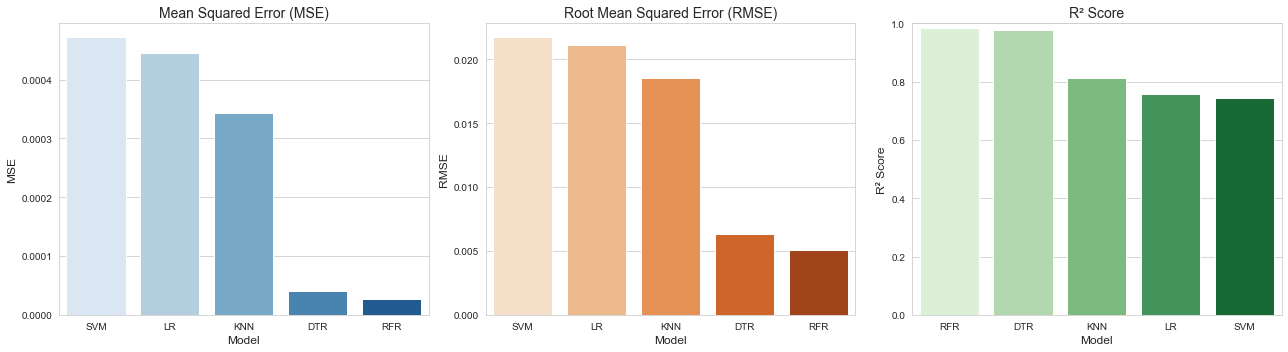

In [44]:
# Add a new column for each model’s metrics
metrics_LR['Model'] = 'LR'
metrics_KNN['Model'] = 'KNN'
metrics_SVM['Model'] = 'SVM'
metrics_DTR['Model'] = 'DTR'
metrics_RFR['Model'] = 'RFR'

# Concatenate all the dataframes into one
combined_metrics = pd.concat([metrics_LR, metrics_KNN, metrics_SVM, metrics_DTR, metrics_RFR], ignore_index=True)

# Pivot the table to have the metrics as columns and the models as rows
pivoted_metrics = combined_metrics.pivot(index='Metric', columns='Model', values='Value')

# Rename index for consistency
pivoted_metrics.rename(index={
    'Mean Squared Error (MSE)': 'MSE',
    'Root Mean Squared Error (RMSE)': 'RMSE',
    'R² Score': 'R2 Score'
}, inplace=True)

# Set plot style
sns.set_style("whitegrid")

# Plot MSE, RMSE, and R² Score
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sorting order for each metric
mse_order = pivoted_metrics.loc['MSE'].sort_values(ascending=False)
rmse_order = pivoted_metrics.loc['RMSE'].sort_values(ascending=False)
r2_order = pivoted_metrics.loc['R2 Score'].sort_values(ascending=False)

# Create color gradients
mse_colors = sns.color_palette("Blues", len(mse_order))
rmse_colors = sns.color_palette("Oranges", len(rmse_order))
r2_colors = sns.color_palette("Greens", len(r2_order))

# MSE
sns.barplot(x=mse_order.index, y=mse_order.values, ax=axes[0], palette=mse_colors)
axes[0].set_title('Mean Squared Error (MSE)', fontsize=14)
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)

# RMSE
sns.barplot(x=rmse_order.index, y=rmse_order.values, ax=axes[1], palette=rmse_colors)
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)

# R² Score
sns.barplot(x=r2_order.index, y=r2_order.values, ax=axes[2], palette=r2_colors)
axes[2].set_title('R² Score', fontsize=14)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylim(0, 1)

# Show plots
plt.tight_layout()
plt.show()


# 7. Discussion and Conclusion

<div style="font-size:18px; line-height:1.8;">
The performance metrics of various regression models—Random Forest Regression (RFR), Decision Tree Regression (DTR), Linear Regression (LR), k-Nearest Neighbors Regression (KNN), and Support Vector Machine Regression (SVM)—demonstrate significant differences in their ability to model the solid holdup distribution in a fluidized bed reactor.
   
Among them, Random Forest Regression (RFR) exhibits the best performance, achieving the lowest Mean Squared Error (MSE) of 0.000018 and the highest R² score of 0.987348. This suggests that RFR effectively captures the complex, non-linear relationships in the data, making it highly suitable for modeling the solid holdup distribution. Additionally, its Root Mean Squared Error (RMSE) of 0.004237 indicates minimal deviation from actual values, reinforcing its predictive accuracy. The strong performance of RFR can be attributed to its ensemble nature, which reduces overfitting and improves generalization.

Decision Tree Regression (DTR) follows as the second-best model, with an R² score of 0.979848 and an MSE of 0.000029. While it successfully captures non-linearities, it does not generalize as well as RFR, likely due to its tendency to overfit the data. Despite this, DTR still outperforms other models in terms of predictive accuracy.

Support Vector Machine Regression (SVM) and Linear Regression (LR) exhibit moderate performance. SVM achieves an R² score of 0.789094 and an MSE of 0.000299, indicating that it struggles with capturing the non-linear patterns in the data, possibly due to improper kernel selection or hyperparameter tuning. Linear Regression (LR) performs similarly, with an R² score of 0.791682 and an MSE of 0.000296, which is expected given its assumption of a linear relationship. Since the solid holdup distribution is inherently non-linear, LR's performance is significantly limited.

Lastly, k-Nearest Neighbors Regression (KNN) emerges as the worst-performing model, with an R² score of 0.704849 and the highest RMSE of 0.020465. This suggests that KNN struggles to capture the complex patterns in the dataset, likely due to its sensitivity to noise and local data distributions.

Overall, Random Forest Regression (RFR) stands out as the most effective model for this task due to its ability to handle non-linearity, capture intricate data patterns, and minimize both MSE and RMSE. The weaker performances of simpler models like Linear Regression and KNN highlight their limitations in modeling complex non-linear phenomena, where ensemble methods like RFR offer better flexibility and accuracy.

# 8. References


- Zheng, Ying, Jing-Xu Zhu, Narenderpal S. Marwaha, and Amarjeet S. Bassi. "Radial solids flow structure in a liquid–solids circulating fluidized bed." Chemical Engineering Journal 88, no. 1 (2002): 141-150.

- Razzak, Shaikh A., Saddam A. Al-Hammadi, Syed M. Rahman, Mohammad R. Quddus, Mohammad M. Hossain, and Jesse Zhu. "Scale-up effect analysis and modeling of liquid–solid circulating fluidized bed risers using multigene genetic programming." Particuology 52 (2020): 57-66.
